<a href="https://colab.research.google.com/github/aeau/MAU-AML-labs/blob/develop/2-language-models-lab/2-text-classifier-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Text Classification ##

This notebook is based on this Pytorch tutorial: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial
        
In this notebook, we will train a network to learn how to classify the country of a name. In this example, we will tokenize per character rather than per word

In [39]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import random
import time
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Change directories to point to your data!
data_path = '/content/drive/MyDrive/Work/PHD/courses-AML/data_aml'
specfic_path = '/content/drive/MyDrive/Work/PHD/courses-AML/data_aml/lm-data.zip'
#!ls "$root_dir"
root_dir = "/content/data"
data_dir = root_dir + "/lm-data/names"


!unzip '/content/drive/MyDrive/Work/PHD/courses-AML/data_aml/lm-data.zip' -d "$root_dir"

Archive:  /content/drive/MyDrive/Work/PHD/courses-AML/data_aml/lm-data.zip
   creating: /content/data/lm-data/
  inflating: /content/data/lm-data/spa-eng.zip  
  inflating: /content/data/__MACOSX/lm-data/._spa-eng.zip  
   creating: /content/data/lm-data/names/
  inflating: /content/data/__MACOSX/lm-data/._names  
  inflating: /content/data/lm-data/.DS_Store  
  inflating: /content/data/__MACOSX/lm-data/._.DS_Store  
  inflating: /content/data/lm-data/eng-fra.txt  
  inflating: /content/data/__MACOSX/lm-data/._eng-fra.txt  
  inflating: /content/data/lm-data/eng-swe.txt  
  inflating: /content/data/__MACOSX/lm-data/._eng-swe.txt  
  inflating: /content/data/lm-data/_about.txt  
  inflating: /content/data/__MACOSX/lm-data/.__about.txt  
  inflating: /content/data/lm-data/swe-eng.zip  
  inflating: /content/data/__MACOSX/lm-data/._swe-eng.zip  
   creating: /content/data/lm-data/book-summaries/
  inflating: /content/data/__MACOSX/lm-data/._book-summaries  
  inflating: /content/data/lm-d

In [41]:
# Vocabulary
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

print(n_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

57
Slusarski


In [42]:
def findFiles(path): return glob.glob(path)

print(findFiles(data_dir + '/*.txt'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(data_dir + '/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(n_categories) # Classes
# print(category_lines)

['/content/data/lm-data/names/Spanish.txt', '/content/data/lm-data/names/Japanese.txt', '/content/data/lm-data/names/Portuguese.txt', '/content/data/lm-data/names/Arabic.txt', '/content/data/lm-data/names/Polish.txt', '/content/data/lm-data/names/Russian.txt', '/content/data/lm-data/names/Czech.txt', '/content/data/lm-data/names/Dutch.txt', '/content/data/lm-data/names/Vietnamese.txt', '/content/data/lm-data/names/Irish.txt', '/content/data/lm-data/names/Scottish.txt', '/content/data/lm-data/names/English.txt', '/content/data/lm-data/names/Greek.txt', '/content/data/lm-data/names/Italian.txt', '/content/data/lm-data/names/German.txt', '/content/data/lm-data/names/French.txt', '/content/data/lm-data/names/Chinese.txt', '/content/data/lm-data/names/Korean.txt']
18


In [44]:
print(category_lines['Greek'][:5])
print(category_lines['Spanish'])

['Adamidis', 'Adamou', 'Agelakos', 'Akrivopoulos', 'Alexandropoulos']
['Abana', 'Abano', 'Abarca', 'Abaroa', 'Abascal', 'Abasolo', 'Abel', 'Abello', 'Aberquero', 'Abreu', 'Acosta', 'Agramunt', 'Aiza', 'Alamilla', 'Albert', 'Albuquerque', 'Aldana', 'Alfaro', 'Alvarado', 'Alvarez', 'Alves', 'Amador', 'Andreu', 'Antunez', 'Aqua', 'Aquino', 'Araujo', 'Araullo', 'Araya', 'Arce', 'Arechavaleta', 'Arena', 'Aritza', 'Armando', 'Arreola', 'Arriola', 'Asis', 'Asturias', 'Avana', 'Azarola', 'Banderas', 'Barros', 'Basurto', 'Bautista', 'Bello', 'Belmonte', 'Bengochea', 'Benitez', 'Bermudez', 'Blanco', 'Blanxart', 'Bolivar', 'Bonaventura', 'Bosque', 'Bustillo', 'Busto', 'Bustos', 'Cabello', 'Cabrera', 'Campo', 'Campos', 'Capello', 'Cardona', 'Caro', 'Casales', 'Castell', 'Castellano', 'Castillion', 'Castillo', 'Castro', 'Chavarria', 'Chavez', 'Colon', 'Costa', 'Crespo', 'Cruz', 'Cuellar', 'Cuevas', "D'cruz", "D'cruze", 'De la cruz', 'De la fuente', 'Del bosque', 'De leon', 'Delgado', 'Del olmo', 'D

### Make everything into one-hot vector ###

For it to be used (transform into a tensor). Here we are doing a character-based one-hot vector

In [47]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(letterToTensor('o'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [48]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.hidden_comp = nn.Linear(input_size + hidden_size, hidden_size)
        self.output_comp = nn.Linear(input_size + hidden_size, hidden_size)
        self.output2output = nn.Linear(hidden_size, output_size)
        self.tanh_act = nn.Tanh()
        self.lsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
#         print(x.shape)
        
        combined = torch.cat((x, hidden), 1)
        hidden = self.hidden_comp(combined)
        hidden = self.tanh_act(hidden)
#         print(hidden.shape)
        
        output = self.output_comp(combined)
        output = self.tanh_act(output)
#         print(output.shape)
        output = self.output2output(output)
        output = self.lsoftmax(output)
#         print(output.shape)
        
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We’ll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

In [50]:
x = letterToTensor('A')
print(x.shape)
hidden =torch.zeros(1, n_hidden)
hidden = rnn.initHidden()
print(hidden.shape)

output, next_hidden = rnn(x, hidden)
print(output.argmax(-1))
print(output.topk(3).indices)

torch.Size([1, 57])
torch.Size([1, 128])
tensor([15])
tensor([[15, 16,  2]])


In [51]:
x = lineToTensor('Alberto')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(x[0], hidden)
output, next_hidden = rnn(x[1], next_hidden)
output, next_hidden = rnn(x[2], next_hidden)
output, next_hidden = rnn(x[3], next_hidden)
output, next_hidden = rnn(x[4], next_hidden)
output, next_hidden = rnn(x[5], next_hidden)
output, next_hidden = rnn(x[6], next_hidden)
print(output.argmax(-1))

tensor([1])


## Preparing for training! ##

In [52]:
# Helper function to get the actual category from the best

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Japanese', 1)


### Quick way to get training example (Src = Name, Trg = Language) ###

In [54]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Scottish / line = Mckenzie
category = French / line = Allard
category = English / line = Downes
category = Dutch / line = Klerks
category = Dutch / line = Laren
category = Japanese / line = Teshima
category = German / line = Wetzel
category = French / line = Babineaux
category = Chinese / line = Juan
category = Chinese / line = Fan


In [55]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


## Train now!!! ##

In [57]:
def train(category_tensor, line_tensor, optim, criterion, model):
    
    model.train()
    hidden = model.initHidden()
    model.zero_grad()
    
    category_tensor = category_tensor.to(device)
    line_tensor = line_tensor.to(device)

    # Iterate through the whole line!
    for i in range(line_tensor.size()[0]):
        hidden = hidden.to(device)
        output, hidden = model(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    
    # zero the parameter gradients
    optim.zero_grad()
    loss.backward()
    optim.step()

    return output, loss.item()

#### Train with the RNN from scrath ####

In [58]:
criterion = nn.NLLLoss() # Because we are using Log_softmax
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
N_HIDDEN = 128

model_basic = RNN(n_letters, N_HIDDEN, n_categories) #Vocab_size, hidden size, output classes
model_basic = model_basic.to(device)
optimizer = optim.SGD(model_basic.parameters(), lr=learning_rate)

n_iters = 10000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor, optimizer, criterion, model_basic)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 50% (0m 8s) 2.3201 Kwei / Korean ✗ (Chinese)
10000 100% (0m 17s) 5.2702 Lis / Korean ✗ (Polish)


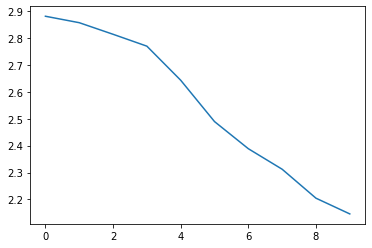

In [59]:
# PLOT THE RESULT

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Evaluate the results with a confusion matrix! ##

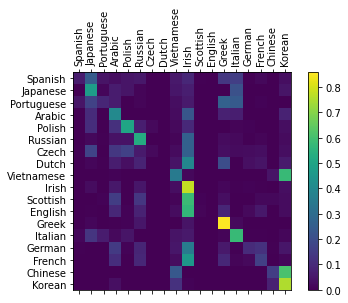

In [60]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor, model):
    model.eval()
    hidden = model.initHidden()
    line_tensor = line_tensor.to(device)

    for i in range(line_tensor.size()[0]):
        hidden = hidden.to(device)
        output, hidden = model(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor, model_basic)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## Now we can try predicting our own things! ##

In [61]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line), model_basic)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Alberto')


> Dovesky
(-1.66) Russian
(-1.90) Polish
(-2.03) Irish

> Jackson
(-1.56) Irish
(-1.81) Scottish
(-1.91) Russian

> Satoshi
(-1.64) Italian
(-1.97) Polish
(-1.98) Japanese

> Alberto
(-1.68) Italian
(-2.04) Portuguese
(-2.10) Spanish


### So now lets shift to using the RNN Module from Pytorch ###

In [62]:
def categoryToTensor(category):
#     tensor = torch.zeros([1, 1], dtype=torch.long)
#     tensor[0][0] = all_categories.index(category)
    tensor = torch.zeros([1, len(all_categories)], dtype=torch.long)
    tensor[0][all_categories.index(category)] = 1
    return tensor

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = categoryToTensor(category)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)
#     print(category_tensor.shape)

category = Irish / line = O'Gorman
category = Spanish / line = De leon
category = Vietnamese / line = Do
category = Portuguese / line = Cardozo
category = Polish / line = Koziol
category = Chinese / line = Chaim
category = Spanish / line = Oriol
category = Russian / line = Jadryshnikov
category = Czech / line = Ponec
category = Scottish / line = Hamilton


In [63]:
class RNNPytorch(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNPytorch, self).__init__()

        self.hidden_size = hidden_size
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True) # 1 is num_layers
        self.fc = nn.Linear(hidden_size, output_size)
        self.lsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):

        hidden, output = self.rnn(x, hidden)

        output = output.contiguous().view(-1, self.hidden_size)
        output = self.fc(output)
        output = self.lsoftmax(output)
        
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(1, 1, self.hidden_size)

In [64]:
def train_pytorch_model(category_tensor, line_tensor, optim, criterion, model):
    
    model.train()
    hidden = model.initHidden(line_tensor.shape[1])
    model.zero_grad()
    line_tensor = line_tensor.permute(1, 0, 2)
#     print(line_tensor.shape)
    
#     print(category_tensor.shape)
    category_tensor = category_tensor.to(device)
    line_tensor = line_tensor.to(device)
    
    # Iterate through the whole line!
    hidden = hidden.to(device)
    output, hidden = model(line_tensor, hidden)

    loss = criterion(output, torch.topk(category_tensor, 1).indices.view(-1))
    
    # zero the parameter gradients
    optim.zero_grad()
    loss.backward()
    optim.step()

    return output, loss.item()

#### Train from the RNN using pytorch approach ####

In [65]:
criterion = nn.NLLLoss() # Because we are using Log_softmax
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
N_HIDDEN = 128

model_pytorch = RNNPytorch(n_letters, N_HIDDEN, n_categories) #Vocab_size, hidden size, output classes
model_pytorch = model_pytorch.to(device)
optimizer = optim.SGD(model_pytorch.parameters(), lr=learning_rate)

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_pytorch_model(category_tensor, line_tensor, optimizer, criterion, model_pytorch)
    current_loss += loss
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 2.9949 Bran / Chinese ✗ (Irish)
10000 10% (0m 13s) 1.1129 Mosconi / Italian ✓
15000 15% (0m 19s) 1.5127 Truong / Korean ✗ (Vietnamese)
20000 20% (0m 26s) 1.1294 Ho / Vietnamese ✓
25000 25% (0m 33s) 3.9603 Wornhor / Scottish ✗ (German)
30000 30% (0m 40s) 1.2015 Kim / Korean ✓
35000 35% (0m 46s) 2.4278 Amato / Japanese ✗ (Italian)
40000 40% (0m 53s) 1.4174 Shaw / Korean ✗ (Chinese)
45000 45% (0m 59s) 0.0204 Shiroyama / Japanese ✓
50000 50% (1m 6s) 0.0722 Nakahara / Japanese ✓
55000 55% (1m 12s) 3.6488 Boutros / Portuguese ✗ (Arabic)
60000 60% (1m 19s) 0.9673 Peatain / French ✗ (Irish)
65000 65% (1m 26s) 0.9108 Alldridge / English ✓
70000 70% (1m 33s) 3.0558 Rheem / Chinese ✗ (Korean)
75000 75% (1m 39s) 0.2855 Pokhlebkin / Russian ✓
80000 80% (1m 46s) 0.2756 Nguyen / Vietnamese ✓
85000 85% (1m 53s) 0.1464 Kalakos / Greek ✓
90000 90% (2m 0s) 0.5290 Fung / Chinese ✓
95000 95% (2m 6s) 0.3938 Dubhan / Irish ✓
100000 100% (2m 13s) 0.3336 Houttum / Dutch ✓


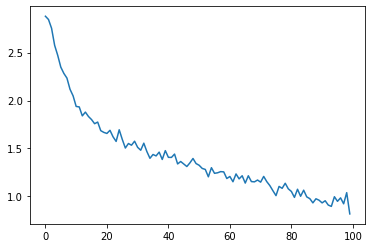

In [66]:
# PLOT THE RESULT

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [67]:
# Just return an output given a line
def evaluate(line_tensor, model):
    model.eval()
    hidden = model.initHidden(line_tensor.shape[1])
    hidden = hidden.to(device)

    line_tensor = line_tensor.permute(1, 0, 2)
    line_tensor = line_tensor.to(device)
    output, hidden = model(line_tensor, hidden)
    
    return output

In [68]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line), model_pytorch)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Alberto')


> Dovesky
(-0.39) Russian
(-2.20) Irish
(-2.34) Czech

> Jackson
(-0.50) Scottish
(-1.83) English
(-2.30) Dutch

> Satoshi
(-0.12) Japanese
(-2.75) Arabic
(-3.28) Polish

> Alberto
(-0.97) Portuguese
(-1.17) Spanish
(-1.43) Italian


## Now one of your assigments is to adapt/expand this text classifier! ##

- Adapt the task to another similar task
- Use LSTMs or GRU to compare with both Vanilla RNN approaches

You can keep it at character-level or you can extend it to word-level (the vocabulary will change)

Try with different datasets with a similar Input/Output system:
- Book or character name -> writer
- Game's titles -> company or genre
- Any word -> language
- Whatever you can think it can be classified